In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import brentq

#General parameters in SI
G=6.6743e-11 #m^3 kg^-1 s^-2
c=3e8 #m/s
h_t=1.054571817e-34 #kg*m^2*s^-2
m_e=9.1093837015e-31 #kg
m_n=1.674927351e-27 #kg
m_sun=1.98855e30 #kg



In [2]:
e0=m_e**4*c**5/(np.pi**2*h_t**3)

#Explicit form of the pressure 

def pressure(x, p_g):
    p=e0/24*((2*x**3-3*x)*(1+x**2)**(1/2)+3*np.arcsinh(x))
    p_diff=p-p_g
    return(p_diff)


#Explicit form of the energy density
def energy(x):
    e_elec=e0/8*((2*x**3+x)*(1+x**2)**(1/2)-np.arcsinh(x))
    k=x*m_e*c
    n=k**3/(3*np.pi**2*h_t**3)
    e_tot=2*n*m_n*c**2+e_elec
    return(e_tot)


#Definition of a function which gives me the corresponding e for a given p
def energy_density(p):
    root = brentq(pressure, -100000, 100000, args=(p))  
    e=energy(root)
    return e



In [3]:
#Define TOV equations using the defined function that gives me the energy density for a given pressure

def tov_equations(r, y):
    p, m = y
    if p <= 0:
        return np.array([0, 0])
    e=energy_density(p)
    dmdr = 4 * np.pi * r**2 * e / c**2
    dpdr = -G * e * m / (c**2 * r**2) * (1 + p / e) * (1 + 4 * np.pi * r**3 * p / (m * c**2)) / (1 - 2 * G * m / (c**2 * r))
    return [dpdr, dmdr]


In [4]:
def solve_tov(p_c):
    y0 = [p_c, 1e-6]  
    r_span = (1e-6, 1e8)
    
    sol = solve_ivp(tov_equations, r_span, y0, method='LSODA', max_step=1e4)
    return sol
            

In [5]:

#pressure in the centre of the neutron star VARYING
p_c_values = np.logspace(19, 39, 200)

# Lists to store results
M_stars = []
r_stars = []


# Solve FOR MANY POSSIBLE INTERNAL PRESSURES
for p_c in p_c_values:
 
    sol = solve_tov(p_c)
    m_values= sol.y[1]/m_sun
    p_values= sol.y[0]
    r_values1=sol.t*10**(-3)

    for i in range(len(p_values)):
        if p_values[i]<=0:
            r_stop = r_values1[i]  # White dwarf's radius
            M_star = m_values[i]  # White dwarf's mass
            break  
    
    
    M_stars.append(M_star)
    r_stars.append(r_stop)
    
    
M_stars = np.array(M_stars)
r_stars = np.array(r_stars)



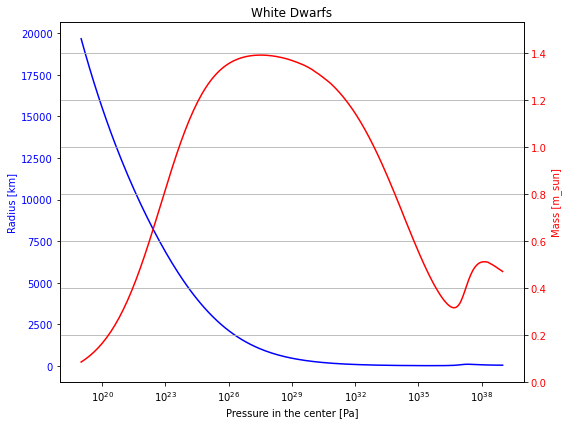

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the first graph (Radius)
ax1.plot(p_c_values, r_stars , 'b-', label="Radius[km]")
ax1.set_xlabel("Pressure in the center [Pa]")
ax1.set_ylabel("Radius [km]", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')

# Create second y-axis (Mass)
ax2 = ax1.twinx() 
ax2.plot(p_c_values, M_stars, 'r-', label="Mass(m_sun)")
ax2.set_ylabel("Mass [m_sun]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.ylim(0, max(M_stars) * 1.1)

plt.title("White Dwarfs")
fig.tight_layout()
plt.grid()
plt.show()



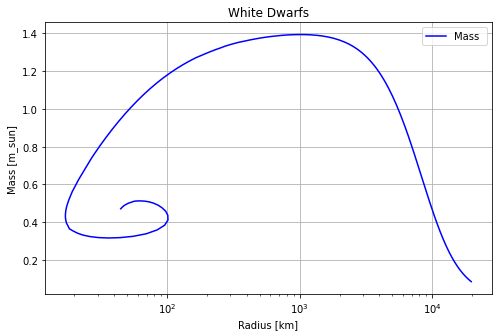

In [7]:
#Plot with R changing
plt.figure(figsize=(8, 5))
plt.plot(r_stars, M_stars, 'b-', label="Mass ")
plt.xlabel('Radius [km]')
plt.ylabel('Mass [m_sun]')
plt.xscale('log')
plt.legend()
plt.title('White Dwarfs')
plt.grid()
plt.show()
